# MNIST digit classification with a fully connected network (fcNN)

Many Thanks to Michael Prummer and Lars Bosshard who adpated large parts of the code from Python to R as part of a DL coaching with Beate.

**Goal:** In this notebook you will see how to use a fully connected networks (fcNN) in an classification task for images.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. Answer the questions asked.

**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of digits and want to classify them into the right label (0-9).

**Content:**
* load the MNIST data 
* transform the labels into the one hot encoding
* visualize samples of the data
* flatten the 2D images into a 1D vector
* use keras to train a fcNN and look at the perfomance on new unseen test data
* use different activation functions and more hidden layers

Original python version 
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_02a.ipynb)


# Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [1]:
#Installing TF and Keras takes approx 2 minutes
ptm <- proc.time()
install.packages("tensorflow") 
install.packages("keras")
install.packages("RCurl")
install.packages("kableExtra")
install.packages("reshape2")
proc.time() - ptm
#devtools::install_github("rstudio/keras") works ok but no tfp
library(keras)
library(tensorflow)
tf$version$VERSION #2.3.0

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘webshot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




   user  system elapsed 
155.968  18.597 181.529 

Loaded Tensorflow version 2.8.2



[1] "2.8.2"

# Imports and loading the data

In the next cell, we load all the required libraries and functions. We download the Mnist data, normalize the pixelvalues to be between 0 and 1, and seperate it into a training and validation set.

In [2]:
library(keras)
library(RCurl)
library(ggplot2)
library(kableExtra)
library(reshape2)

## Loading and preparing the MNIST data and transfering the labels into the one hot encoding

Here we load the MNIST dataset form keras. The 8-bit greyscale images have values form 0 to 255, we divide all values with 255 so that the values are in a range between 0 and 1. In additon we transform the true labels, which are the numbers from 0 to 9 (the digit on the image) into the one hot encoding. We do this to make use of linear algebra in the calculation of the crossentropy loss.  
  
The one hot encoding transforms the labels into a vector with the same length as we have labels (in our case 10). The resulting vector in the one hot encodig is zero everywhere except for the position of the true label, there it is 1. Let's look at some examples to make it more clear:  

0 becomes [1,0,0,0,0,0,0,0,0,0]  
1 becomes [0,1,0,0,0,0,0,0,0,0]  
2 becomes [0,0,1,0,0,0,0,0,0,0]  
...  
9 becomes [0,0,0,0,0,0,0,0,0,1]  

In [3]:
mnist = dataset_mnist()
x_train = mnist$train$x[1:50000, , ] / 255
y_train = to_categorical(mnist$train$y[1:50000],   # one-hot encoding
                         num_classes = length(unique(mnist$train$y)))
x_val = mnist$train$x[50001:60000, , ] / 255
y_val = to_categorical(mnist$train$y[50001:60000],
                         num_classes = length(unique(mnist$train$y)))
x_test = mnist$test$x / 255
y_test = to_categorical(mnist$test$y, 
                        num_classes = length(unique(mnist$test$y)))
true_class = mnist$test$y
rm(mnist)

x_train = array_reshape(x_train, c(dim(x_train), 1))
x_val = array_reshape(x_val, c(dim(x_val), 1))
x_test = array_reshape(x_test, c(dim(x_test), 1))

In [4]:
dim(x_train)

[1] 50000    28    28     1

## Visualization of the data set
Let's visualize the first 36 mnist images. It is very easy to recognise the true label of the digits.


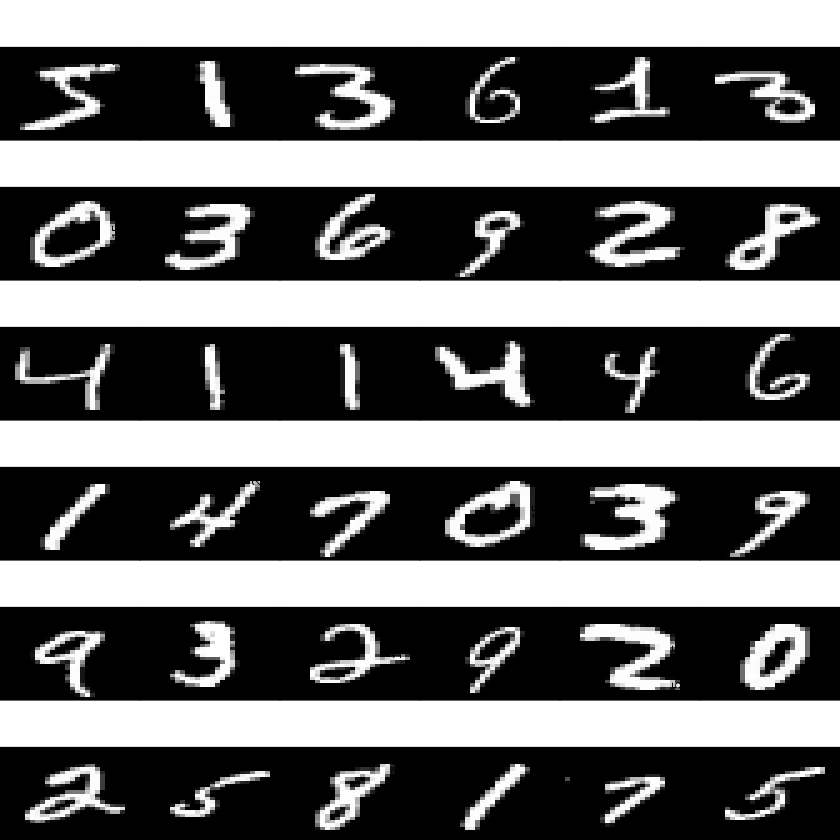

In [5]:
# visualize the digits, see https://stackoverflow.com/questions/37953644/r-image-plot-mnist-dataset
par(mfcol=c(6,6))
par(mar=c(0, 0, 3, 0), xaxs='i', yaxs='i')
for (idx in 1:36) { 
    im <- x_train[idx,,,1]
    im <- t(apply(im, 2, rev)) 
    image(1:28, 1:28, im, col=gray((0:255)/255), xaxt='n')
}

# fcNN as classification model for MNIST data
Now we want to train a fcNN to classify the MNIST data.
* we use a fcNN with 2 hidden layers and use the sigmoid activation function
* train it on train data and check the performance on the test data


## Flatten the data
Because we will use fcNN our input cannot be matrices or tensors. We need to flatten our input into a 1d vector. We do this in the next cell with reshap and look at the resulting shape of the flattened data.

In [6]:
# first do it for original data
x_train_flat = array(x_train, dim=c(dim(x_train)[1], dim(x_train)[2] * dim(x_train)[3]))
x_val_flat = array(x_val, dim=c(dim(x_val)[1], dim(x_val)[2] * dim(x_val)[3]))
x_test_flat = array(x_test, dim=c(dim(x_test)[1], dim(x_test)[2] * dim(x_test)[3]))

In [7]:
dim(x_train_flat)

[1] 50000   784

## Definition of the network

Here we define the nework, we use two hidden layers with 100 and 50 nodes. In the output we predict the probability for the 10 digits with the softmax actication function, in the hidden layers we use the sigmoid activation function and our loss is the categroical crossentropy loss.


In [10]:
model = keras_model_sequential() 
model = layer_dense(model, units =  100, activation = 'relu', input_shape = c(784))
model = layer_dense(model, units = 50, activation = 'relu')
model = layer_dense(model, units = 10, activation = 'softmax')
# compile model and intitialize weights
model = compile(model, optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
# summarize model along with number of model weights
summary(model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense (Dense)                      (None, 100)                     78500       
 dense_1 (Dense)                    (None, 50)                      5050        
 dense_2 (Dense)                    (None, 10)                      510         
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
________________________________________________________________________________


**Questions**

* Can you explain the number of parameters of the first layer / of all layers? 
* Think a bit before you scroll down


In [30]:
#@title Solution { display-mode: "form" }
784*100 + 100 #First Layer

784*100 + 100 + #First Layer (including the bias term) 
100*50 + 50 + #Second Layer
50*10 + 10

[1] 78500

[1] 84060

## Loss of untrained network

The following code evaluates the test loss and the accuracy of an untrained network. 

In [12]:
model$evaluate(x_test_flat, y_test)

[1] 2.325149 0.109900

In [32]:
#@title The loss of the untrained network is about 2.3 can you explain that number { display-mode: "form" }
-log(0.1)

[1] 2.302585

## Training of the model

In [14]:
history = fit(model, x_train_flat, y_train, batch_size=128, epochs=5, verbose=2, 
              validation_data=list(x_val_flat, y_val))

In the next cell we plot the accuray and loss of the train and validation vs the number of train eprochs to see how the development

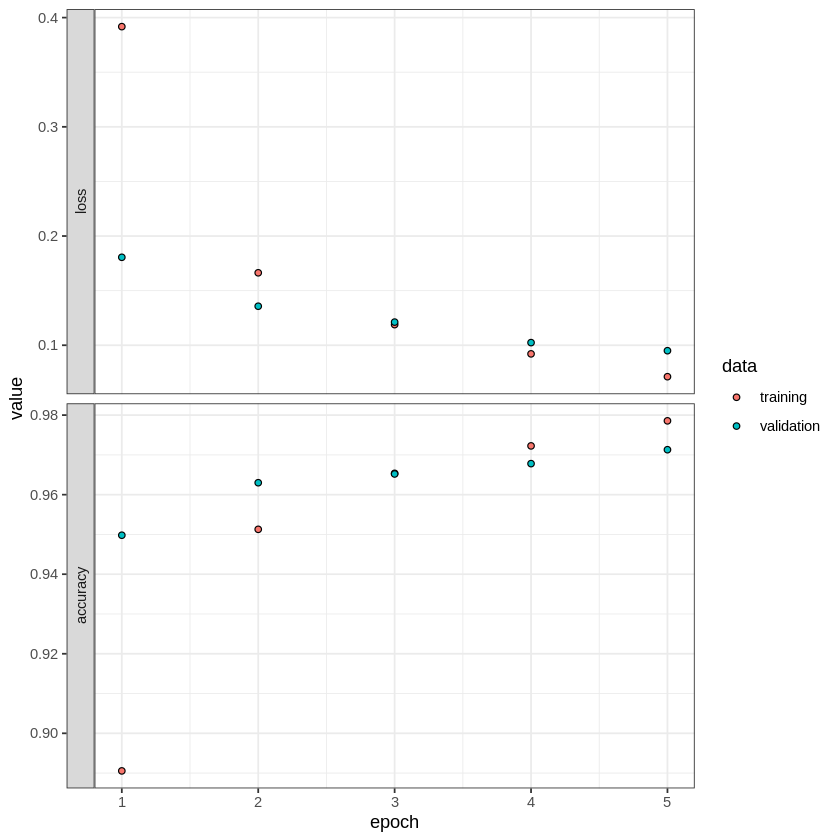

In [15]:
plot(history) + theme_bw()

## Prediction on the original test set after training on original data

Now, let's use the fcNN that was trained on the flattened MNIST data to predict new unseen data (our testdata).
We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.


In [16]:
pred = predict(model, x_test_flat)

In [17]:
head(pred)

1.394386e-07,3.453674e-08,2.555326e-04,1.319605e-03,1.500449e-10,1.748962e-06,3.277820e-09,9.984085e-01,7.751236e-06,6.822056e-06
4.234283e-07,1.156809e-03,9.981186e-01,5.600160e-04,7.047604e-11,1.403521e-04,5.460678e-06,9.689061e-11,1.832404e-05,5.979744e-10
1.738581e-05,9.967141e-01,6.508305e-04,2.369580e-04,1.546914e-04,2.604270e-05,5.383703e-05,1.842460e-03,2.339449e-04,6.974342e-05
9.995669e-01,5.248397e-07,7.793689e-05,1.289718e-05,2.521622e-06,4.705356e-05,1.298232e-04,9.909202e-05,1.473630e-07,6.316381e-05
1.610102e-05,5.463822e-06,3.637360e-05,1.072880e-05,8.973444e-01,3.549598e-07,9.846967e-06,6.822008e-05,7.383296e-05,1.024347e-01
6.913982e-07,9.985927e-01,1.519898e-05,1.781372e-05,1.576344e-05,1.324613e-07,1.095429e-07,1.322667e-03,2.780346e-06,3.213023e-05


In [18]:
head(y_test)

0,0,0,0,0,0,0,1,0,0
0,0,1,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0


In [19]:
pred = k_argmax(predict(model, x_test_flat))
pred$numpy()

[1] 7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2
   [37] 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0
   [73] 2 9 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1
  [109] 9 4 8 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1
  [145] 7 1 8 2 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8
  [181] 1 8 5 0 8 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0
  [217] 3 6 5 5 7 2 2 7 1 2 8 4 1 7 3 3 8 8 7 9 2 2 4 1 5 9 8 7 2 3 0 2 4 2 4 1
  [253] 9 5 7 7 2 8 2 0 8 5 7 7 9 1 8 1 8 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4
  [289] 1 5 8 2 9 2 0 4 0 0 2 8 4 7 1 2 4 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5 9 7 9 3
  [325] 0 4 2 0 7 1 1 2 1 5 3 3 9 7 8 6 3 6 1 3 8 1 0 5 1 3 1 5 5 6 1 8 5 1 7 9
  [361] 4 6 2 2 5 0 6 5 6 3 7 2 0 8 8 5 4 1 1 4 0 3 3 7 6 1 6 2 1 9 2 8 6 1 9 5
  [397] 2 5 4 4 2 8 3 8 2 4 5 0 3 1 7 7 5 7 9 7 1 9 2 1 4 2 9 2 0 4 9 1 4 8 1 8
  [433] 4 5 9 8 8 3 7 6 0 0 3 0 2 0 6 4 9 3 3 3 2 3 9 1 2 6 8 0 5 6 6 6 3 8 8 2
  [469] 7 5 8 9 6 1 8 4 1 2 5 9 1 9 7 5 4 0 8 9 9 1 0 5 2 3 7 0 9 4 0 6 3 9 5 2
  [505] 1 3 1 3 6 5 7 4 2 2 6 3 2 6 5 4 8 9 3 1 3 0 3 8 3 1 9 3 4 4 6 4 2 1 8 2
  [541] 5 4 8 8 4 0 0 2 3 2 7 7 0 8 7 4 4 7 9 6 9 0 9 8 0 9 6 0 6 3 5 4 8 3 3 9
  [577] 3 3 7 7 8 0 2 2 1 7 0 6 5 4 3 8 0 9 6 3 8 0 9 9 6 8 6 8 5 7 8 6 0 2 4 0
  [613] 2 2 3 1 9 7 5 8 0 8 4 6 2 6 7 9 3 2 9 8 2 2 9 2 7 3 5 9 1 8 0 2 0 5 2 1
  [649] 3 7 6 7 1 2 5 8 0 3 7 1 4 0 9 1 8 6 7 7 4 3 4 9 1 9 5 1 7 3 9 7 6 9 1 3
  [685] 3 8 3 3 6 7 2 4 5 8 5 1 1 4 4 3 1 0 7 7 0 7 9 4 4 8 5 5 4 0 8 2 1 6 8 4
  [721] 8 0 4 0 6 1 7 3 2 6 7 2 6 9 3 1 4 6 2 5 9 2 0 6 2 1 7 3 4 1 0 5 4 3 1 1
  [757] 7 4 9 9 9 8 4 0 2 4 5 1 1 6 4 7 1 9 4 2 4 1 5 5 3 8 3 1 4 5 5 8 9 4 1 5
  [793] 3 8 0 3 2 5 1 2 8 3 4 4 0 8 8 3 3 1 7 3 5 9 6 3 2 6 1 3 6 0 7 2 1 7 1 4
  [829] 2 4 2 1 7 9 6 1 1 2 4 8 1 7 7 4 7 0 7 3 1 3 1 0 7 7 0 3 5 5 2 7 6 6 9 2
  [865] 8 3 5 2 2 5 6 0 8 2 9 2 8 8 8 8 7 9 9 3 0 6 6 3 2 1 3 2 2 9 3 0 0 5 7 8
  [901] 1 4 4 6 0 2 9 1 4 7 4 7 3 9 8 8 4 7 1 2 1 2 2 3 2 3 2 3 9 1 7 4 0 3 5 5
  [937] 8 6 3 2 6 7 6 6 3 2 7 9 1 1 7 4 6 4 9 5 1 3 3 9 7 8 9 1 1 0 9 1 4 4 5 4
  [973] 0 6 2 2 3 1 5 1 2 0 3 8 1 2 6 7 1 6 2 3 9 0 1 2 2 0 8 9 9 0 2 3 1 9 7 8
 [1009] 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 8 8 0 6 2 1 1 1 1 5 3 4
 [1045] 2 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9 2 2 3 3 8 3 5 7 3 5 8 1 2 4 4 6
 [1081] 4 9 5 1 0 6 9 5 9 5 9 7 3 8 0 3 7 1 3 6 7 8 5 9 7 9 6 3 6 3 7 4 6 5 3 5
 [1117] 4 7 8 7 8 0 7 6 8 8 7 3 7 1 9 5 2 7 3 5 1 1 2 1 4 7 4 7 5 4 5 4 0 8 3 6
 [1153] 9 6 0 2 7 4 4 4 4 6 6 4 7 9 3 4 5 5 8 7 3 7 2 7 0 2 4 1 1 1 8 9 2 8 7 2
 [1189] 0 1 5 7 9 1 9 0 6 0 8 6 8 1 8 0 3 3 7 2 3 6 2 1 6 1 1 3 7 9 0 8 0 5 4 0
 [1225] 2 8 2 2 9 8 4 0 4 5 8 5 1 2 1 3 1 7 4 5 7 2 0 5 8 8 6 2 5 4 1 9 2 1 5 8
 [1261] 1 0 2 4 4 3 6 8 8 2 4 0 5 0 4 4 7 9 3 4 1 5 9 7 3 5 8 8 0 5 3 3 6 6 0 1
 [1297] 6 0 3 7 4 4 1 2 9 1 4 6 9 9 3 9 8 4 4 3 1 3 1 3 8 7 9 4 8 8 1 9 7 1 4 5
 [1333] 6 0 5 2 2 6 1 5 5 2 4 9 6 2 7 7 2 2 1 1 2 8 3 7 2 4 1 7 1 7 6 7 8 2 7 3
 [1369] 1 7 5 8 2 6 2 2 5 6 6 0 9 2 4 3 3 9 7 6 6 8 0 4 1 3 8 2 9 1 8 0 6 7 2 1
 [1405] 0 5 5 2 0 2 2 0 2 4 9 8 0 9 9 4 6 5 4 9 1 8 3 4 9 9 1 2 2 8 1 9 6 4 0 9
 [1441] 4 8 3 8 6 0 2 5 1 9 6 2 9 4 0 9 6 0 6 2 5 4 2 3 8 4 5 5 9 3 8 5 3 5 8 6
 [1477] 5 7 6 3 3 9 6 1 1 2 9 0 4 3 3 6 9 5 7 3 7 7 7 8 1 9 8 3 0 7 2 7 9 4 5 4
 [1513] 9 3 2 1 4 0 2 3 7 5 9 8 8 5 0 1 1 4 7 3 9 0 0 0 6 6 2 3 7 8 4 7 7 9 2 4
 [1549] 1 6 5 2 4 3 9 1 8 4 0 9 8 4 8 7 7 0 7 8 8 6 0 4 8 8 2 4 7 6 6 6 4 7 1 8
 [1585] 8 2 3 6 3 0 0 3 7 6 9 7 9 9 5 4 3 7 6 1 2 3 7 3 3 6 0 3 3 8 4 3 6 3 5 0
 [1621] 2 0 9 0 7 4 6 9 3 5 1 9 6 1 4 5 4 5 0 5 9 5 2 1 2 9 1 9 9 4 0 8 4 5 2 9
 [1657] 2 1 2 1 7 3 6 8 8 4 9 1 9 8 5 3 5 1 1 8 6 5 2 4 4 7 2 3 5 6 8 8 6 2 3 1
 [1693] 0 5 8 9 2 9 6 7 0 4 8 7 1 7 4 1 0 3 7 2 0 0 9 1 7 0 7 8 4 7 2 0 4 6 0 3
 [1729] 1 1 3 3 9 6 7 4 1 5 3 0 8 7 3 9 6 9 3 5 0 2 7 4 5 1 3 5 8 0 8 8 1 5 0 3
 [1765] 0 3 1 4 0 3 7 2 7 6 8 0 7 0 4 3 1 9 8 7 7 1 4 9 9 3 8 1 7 9 0 2 0 3 3 7
 [18

In [20]:
#pred = model %>% predict(x_test_flat) %>% k_argmax()
true_class2 = apply(y_test, 1, which.max) - 1
table(true_class2, pred$numpy())
mean(true_class2 == pred$numpy())

           
true_class2    0    1    2    3    4    5    6    7    8    9
          0  953    0    1    3    3    4    4    5    1    6
          1    0 1124    2    1    0    0    3    0    5    0
          2    3    2  995    7    2    0    5   11    7    0
          3    0    0    0  997    0    2    0    6    3    2
          4    0    0    2    1  951    1    4    4    1   18
          5    1    0    0   17    1  860    6    1    4    2
          6    4    3    4    1    6    5  931    1    3    0
          7    0    8    5    7    0    0    0  999    0    9
          8    4    2    1   14    4    5    2    4  934    4
          9    0    4    0   10    7    4    0    6    0  978

[1] 0.9722

In [21]:
model$evaluate(x_test_flat, y_test) #Alternative version

[1] 0.09144074 0.97219998

# Additional Task

Play the deep learning game and stack more layers and change the activation function from sigmoid to relu


<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*Exercise: Try to improve the fcNN by adding more hidden layers and/or changing the activation function from "sigmoid" to "relu". What do you observe? can you improve the performace on the testset?*

In [22]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.4   kableExtra_1.3.4 ggplot2_3.3.6    RCurl_1.98-1.8  
[5] tensorflow_2.9.0 keras_2.9.0     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9        svglite_2.1.0     here_1.0.1        lattice_0.20-45  
 [5] png_0.1-7         assertthat_0.2.1